Working File for ResNet18

In [5]:
# ==== Data / Dataloaders for ResNet18 ====

import os, csv
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ---- Paths ----
CSV_DIR    = Path(r"C:\Users\Andre\Documents\Machine Learning Project\processed_csvs")
IMAGE_ROOT = CSV_DIR  # images live under this root

# ---- Label mapping (keep consistent across models) ----
LABEL_TO_IDX = {"clear": 0, "obstructed": 1}

# ---- Normalization (ImageNet) ----
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def get_transforms():
    """Baseline transforms (no RandAugment) for ResNet18."""
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return train_tf, eval_tf

train_tf, eval_tf = get_transforms()

class CSVDataset(Dataset):
    def __init__(self, csv_path, transform, image_root=None):
        self.rows = []
        self.transform = transform
        self.image_root = image_root

        with open(csv_path, "r", newline="") as f:
            r = csv.DictReader(f)
            assert {"filename","label"}.issubset(r.fieldnames), f"Missing headers in {csv_path}"
            for row in r:
                fp = row["filename"].strip()
                if image_root is not None and not os.path.isabs(fp):
                    fp = str(Path(image_root) / fp)
                lab = row["label"].strip().lower()
                assert lab in LABEL_TO_IDX, f"Unknown label {lab} in {csv_path}"
                self.rows.append((fp, LABEL_TO_IDX[lab]))

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        img_path, y = self.rows[idx]
        with Image.open(img_path) as im:
            im = im.convert("RGB")
        x = self.transform(im)
        return x, torch.tensor(y, dtype=torch.long)

def make_loaders(batch_size=64, num_workers=0, pin_memory=True):
    train_csv = CSV_DIR / "train.csv"
    val_csv   = CSV_DIR / "val.csv"
    test_csv  = CSV_DIR / "test.csv"

    train_ds = CSVDataset(train_csv, transform=train_tf, image_root=IMAGE_ROOT)
    val_ds   = CSVDataset(val_csv,   transform=eval_tf,  image_root=IMAGE_ROOT)
    test_ds  = CSVDataset(test_csv,  transform=eval_tf,  image_root=IMAGE_ROOT)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds

# Instantiate once in the notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders(
    batch_size=64,
    num_workers=0,   # safest on Windows + Jupyter
    pin_memory=True
)

print("Label mapping:", LABEL_TO_IDX)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))

xb, yb = next(iter(train_loader))
print("Batch x shape:", xb.shape)
print("Batch y shape:", yb.shape)
print("Unique labels in batch:", sorted(set(yb.tolist())))
print("Device available:", device)


Label mapping: {'clear': 0, 'obstructed': 1}
Train size: 14000 Val size: 3000 Test size: 3000
Batch x shape: torch.Size([64, 3, 224, 224])
Batch y shape: torch.Size([64])
Unique labels in batch: [0, 1]
Device available: cuda


In [2]:
# ==== Training: ResNet18 baseline ====

import time
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2  # clear / obstructed

def run_one_epoch(model, loader, criterion, optimizer, scaler, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    t0 = time.time()

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.size(0)

    dt = time.time() - t0
    return loss_sum/total, correct/total, dt

def train_resnet18():
    # 1) Data
    train_loader, val_loader, _, _, _, _ = make_loaders(
        batch_size=64,
        num_workers=0,
        pin_memory=True
    )

    # 2) Model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)
    model = model.to(device)

    # 3) Loss / Optimizer / Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    # 4) Train loop
    EPOCHS = 8
    best_val = 0.0
    best_path = "resnet18_clear_obstructed_best.pt"

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_dt = run_one_epoch(
            model, train_loader, criterion, optimizer, scaler, train=True
        )
        va_loss, va_acc, va_dt = run_one_epoch(
            model, val_loader,   criterion, optimizer, scaler, train=False
        )

        scheduler.step(va_acc)

        print(f"epoch {epoch:02d} | "
              f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} ({tr_dt:.1f}s) | "
              f"val:   loss {va_loss:.4f} acc {va_acc:.3f} ({va_dt:.1f}s) | "
              f"lr: {optimizer.param_groups[0]['lr']:.2e}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)
            print(f"  ⮕ saved best to {best_path} (val_acc={best_val:.3f})")

    print("Training done. Best val_acc:", f"{best_val:.3f}")
    return best_path, best_val

# In the notebook, run:
best_path_r18, best_val_r18 = train_resnet18()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Andre/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


epoch 01 | train: loss 0.5024 acc 0.755 (141.0s) | val:   loss 0.2613 acc 0.895 (27.6s) | lr: 3.00e-04
  ⮕ saved best to resnet18_clear_obstructed_best.pt (val_acc=0.895)
epoch 02 | train: loss 0.4519 acc 0.784 (138.5s) | val:   loss 0.2612 acc 0.894 (28.2s) | lr: 3.00e-04
epoch 03 | train: loss 0.4429 acc 0.790 (141.9s) | val:   loss 0.2597 acc 0.891 (28.1s) | lr: 3.00e-04
epoch 04 | train: loss 0.4289 acc 0.796 (139.1s) | val:   loss 0.2299 acc 0.911 (27.8s) | lr: 3.00e-04
  ⮕ saved best to resnet18_clear_obstructed_best.pt (val_acc=0.911)
epoch 05 | train: loss 0.4278 acc 0.795 (142.7s) | val:   loss 0.2223 acc 0.914 (27.5s) | lr: 3.00e-04
  ⮕ saved best to resnet18_clear_obstructed_best.pt (val_acc=0.914)
epoch 06 | train: loss 0.4222 acc 0.796 (139.7s) | val:   loss 0.2406 acc 0.905 (27.2s) | lr: 3.00e-04
epoch 07 | train: loss 0.4208 acc 0.801 (138.3s) | val:   loss 0.2298 acc 0.907 (27.1s) | lr: 3.00e-04
epoch 08 | train: loss 0.4221 acc 0.798 (139.6s) | val:   loss 0.2584 acc 0

In [8]:
# ==== Evaluation: ResNet18 on test set ====

import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_resnet18_checkpoint(best_weights_path):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 2)
    model.load_state_dict(torch.load(best_weights_path, map_location=device))
    model.to(device)
    model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # [[TN, FP],[FN, TP]]
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:  # test_loader from data cell
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): return a / b if b > 0 else 0.0

    # same convention as your other models
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(2 * prec_clear * rec_clear, prec_clear + rec_clear) if (prec_clear + rec_clear) > 0 else 0.0

    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(2 * prec_obst * rec_obst, prec_obst + rec_obst) if (prec_obst + rec_obst) > 0 else 0.0

    print("Test accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }

# After training:
acc_r18, cm_r18, metrics_r18 = eval_resnet18_checkpoint(
    "resnet18_clear_obstructed_best.pt"
)


C:\Users\Andre\AppData\Local\Temp\ipykernel_21104\556034017.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_weights_path, map_loca

Test accuracy: 0.915
Confusion matrix (rows=true, cols=pred):
[[1589, 140], [116, 1155]]
Per-class metrics:
  clear (0):       precision 0.932  recall 0.919  f1 0.925
  obstructed (1):  precision 0.892  recall 0.909  f1 0.900


In [9]:
# ==== Latency & Throughput — ResNet18 ====

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# Change this ONLY when you want to test a different ResNet18 checkpoint
R18_BEST_WEIGHTS = r"C:\Users\Andre\Documents\Machine Learning Project\resnet18_clear_obstructed_best.pt"


@torch.no_grad()
def benchmark(model, loader, warmup=20, iters=200):
    model.eval()

    # grab one single-image batch and one full batch from the loader
    xb1, _ = next(iter(loader))
    xb1 = xb1[:1].to(device)   # [1, 3, 224, 224]
    xbB, _ = next(iter(loader))
    xbB = xbB.to(device)       # [B, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
            _ = model(xbB)
    if device.type == "cuda":
        torch.cuda.synchronize()

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xbB)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return (m1, p951, fps_single), (mB, p95B, fps_batch), bsz


def benchmark_resnet18(weights_path: str):
    """
    Build ResNet18 with a 2-class head, load weights from `weights_path`,
    and benchmark latency & throughput using the existing `test_loader`.
    """
    global test_loader  # uses the test_loader created in your data/dataloaders cell

    # Rebuild architecture (no pretrained weights; we load your trained checkpoint)
    model = models.resnet18(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)

    (m1, p951, fps1), (mB, p95B, fpsB), bsz = benchmark(model, test_loader)

    print(f"Checkpoint: {weights_path}")
    print(f"Single image:  mean {m1:.2f} ms  p95 {p951:.2f} ms  FPS ~{fps1:.1f}")
    print(f"Batch ({bsz}): mean {mB:.2f} ms  p95 {p95B:.2f} ms  Throughput ~{fpsB:.1f} img/s")

    return {
        "weights": weights_path,
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps1,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fpsB,
        "batch_size": bsz,
    }


# Run this to benchmark the current ResNet18 baseline:
r18_latency_stats = benchmark_resnet18(R18_BEST_WEIGHTS)


C:\Users\Andre\AppData\Local\Temp\ipykernel_21104\1370364395.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Checkpoint: C:\Users\Andre\Documents\Machine Learning Project\resnet18_clear_obstructed_best.pt
Single image:  mean 1.69 ms  p95 2.08 ms  FPS ~591.6
Batch (64): mean 11.81 ms  p95 12.88 ms  Throughput ~5419.8 img/s


Dynamic Quantization - Post-Training

In [10]:
# === Apply FX-based Static Quantization (ResNet18) ===

import torch
import torch.nn as nn
from torchvision import models

# Version-robust imports for FX quantization
from torch.ao.quantization import get_default_qconfig, QConfigMapping

try:
    # Newer PyTorch: FX APIs live here
    from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
except ImportError:
    # Older PyTorch: sometimes under torch.quantization.quantize_fx
    from torch.quantization.quantize_fx import prepare_fx, convert_fx

# Paths
R18_BEST_WEIGHTS   = "resnet18_clear_obstructed_best.pt"
R18_QUANT_FX_PATH  = "resnet18_clear_obstructed_quant_fx.pt"

# Quantization is CPU-only
quant_device = torch.device("cpu")
NUM_CLASSES  = 2  # clear / obstructed


def build_r18_fp32_for_quant(weights_path: str) -> nn.Module:
    """
    Rebuild ResNet18 with a 2-class head and load trained FP32 weights.
    Model is returned on CPU in eval mode, ready for FX PTQ.
    """
    # We don't need pretrained weights here; we load your trained checkpoint
    model = models.resnet18(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to(quant_device)
    model.eval()
    return model


def calibrate_model_r18(prepared_model: nn.Module, loader, num_batches: int = 20):
    """
    Run a few batches through the prepared model to collect activation stats
    for post-training static quantization.
    """
    prepared_model.eval()
    with torch.inference_mode():
        for i, (xb, _) in enumerate(loader):
            xb = xb.to(quant_device)
            _ = prepared_model(xb)
            if i >= num_batches - 1:
                break


def apply_fx_static_quantization_resnet18(
    fp32_weights_path: str,
    calib_loader,
    num_calib_batches: int = 20,
):
    """
    Full FX-based PTQ pipeline for ResNet18:
      - build FP32 model
      - prepare FX graph with qconfig
      - calibrate on a few calibration batches
      - convert to quantized model
      - save quantized model to disk
    """
    # 1) Build FP32 model
    fp32_model = build_r18_fp32_for_quant(fp32_weights_path)

    # 2) Define qconfig mapping (global int8 config for x86/AVX: "fbgemm")
    qconfig = get_default_qconfig("fbgemm")
    qconfig_mapping = QConfigMapping().set_global(qconfig)

    # 3) Example input for FX tracing
    example_inputs = torch.randn(1, 3, 224, 224, device=quant_device)

    # 4) Prepare model for FX PTQ
    prepared_model = prepare_fx(fp32_model, qconfig_mapping, example_inputs)

    # 5) Calibrate with real data
    calibrate_model_r18(prepared_model, calib_loader, num_batches=num_calib_batches)

    # 6) Convert to quantized model
    quantized_model = convert_fx(prepared_model)
    quantized_model.to(quant_device)
    quantized_model.eval()

    # 7) Save quantized model (state_dict) for size comparison / reload
    torch.save(quantized_model.state_dict(), R18_QUANT_FX_PATH)
    print(f"Saved FX-quantized ResNet18 to: {R18_QUANT_FX_PATH}")

    return quantized_model


# Run FX-based PTQ using the existing train_loader for calibration
print("\n=== Applying FX-based Static Quantization to ResNet18 ===")
r18_quant_fx = apply_fx_static_quantization_resnet18(
    R18_BEST_WEIGHTS,
    calib_loader=train_loader,   # or val_loader if you prefer
    num_calib_batches=20         # can tune up/down
)
print("FX-based static quantization for ResNet18 complete.")



=== Applying FX-based Static Quantization to ResNet18 ===


C:\Users\Andre\AppData\Local\Temp\ipykernel_21104\565868258.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")
x:\mini

Saved FX-quantized ResNet18 to: resnet18_clear_obstructed_quant_fx.pt
FX-based static quantization for ResNet18 complete.


In [11]:
# === Evaluate FX-Quantized ResNet18 on Test Set ===

import torch

def eval_r18_quant_fx(quantized_model, test_loader):
    """
    Evaluate FX-quantized ResNet18 on the test set with the same
    metrics as the FP32 baseline.
    """
    quantized_model.to("cpu")
    quantized_model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # rows=true, cols=pred
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to("cpu")
            yb = yb.to("cpu")

            logits = quantized_model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): return a / b if b > 0 else 0.0

    # metrics for clear (class 0)
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(
        2 * prec_clear * rec_clear,
        prec_clear + rec_clear
    ) if (prec_clear + rec_clear) > 0 else 0.0

    # metrics for obstructed (class 1)
    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(
        2 * prec_obst * rec_obst,
        prec_obst + rec_obst
    ) if (prec_obst + rec_obst) > 0 else 0.0

    print("FX-Quantized ResNet18 Test Accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }


print("\n=== Evaluating FX-Quantized ResNet18 on Test Set ===")
acc_r18_quant_fx, cm_r18_quant_fx, metrics_r18_quant_fx = eval_r18_quant_fx(
    r18_quant_fx,  # from the ResNet18 FX quantization cell
    test_loader
)



=== Evaluating FX-Quantized ResNet18 on Test Set ===
FX-Quantized ResNet18 Test Accuracy: 0.915
Confusion matrix (rows=true, cols=pred):
[[1593, 136], [119, 1152]]
Per-class metrics:
  clear (0):       precision 0.930  recall 0.921  f1 0.926
  obstructed (1):  precision 0.894  recall 0.906  f1 0.900


In [12]:
# === Compare Model Sizes (FP32 vs FX-Quantized ResNet18) ===

import os

def get_model_size_mb(model_path: str) -> float:
    """Get model size in megabytes from a file on disk."""
    size_bytes = os.path.getsize(model_path)
    return size_bytes / (1024 * 1024)


R18_BASELINE_PATH  = "resnet18_clear_obstructed_best.pt"
R18_QUANT_FX_PATH  = "resnet18_clear_obstructed_quant_fx.pt"

baseline_r18_size_mb  = get_model_size_mb(R18_BASELINE_PATH)
quant_r18_fx_size_mb  = get_model_size_mb(R18_QUANT_FX_PATH)
compression_r18_ratio = baseline_r18_size_mb / quant_r18_fx_size_mb

print("\n=== Model Size Comparison (ResNet18) ===")
print(f"Baseline (FP32) Checkpoint Size:      {baseline_r18_size_mb:.2f} MB")
print(f"FX-Quantized (INT8) Checkpoint Size:  {quant_r18_fx_size_mb:.2f} MB")
print(f"Compression Ratio (baseline / quant): {compression_r18_ratio:.2f}x")
print(f"Size Reduction:                       {(1 - quant_r18_fx_size_mb / baseline_r18_size_mb) * 100:.1f}%")



=== Model Size Comparison (ResNet18) ===
Baseline (FP32) Checkpoint Size:      42.72 MB
FX-Quantized (INT8) Checkpoint Size:  10.79 MB
Compression Ratio (baseline / quant): 3.96x
Size Reduction:                       74.7%


In [13]:
# === Latency & Throughput Benchmark for Baseline & FX-Quantized ResNet18 (CPU) ===

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 2
R18_BEST_WEIGHTS = "resnet18_clear_obstructed_best.pt"  # adjust if using absolute path


def build_baseline_r18(weights_path: str) -> nn.Module:
    """
    Rebuild baseline ResNet18 with 2-class head and load FP32 trained weights.
    Returned model is on CPU in eval mode.
    """
    model = models.resnet18(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to("cpu")
    model.eval()
    return model


# Baseline FP32 model
baseline_r18 = build_baseline_r18(R18_BEST_WEIGHTS)

# Quantized model: r18_quant_fx should have been created in the FX PTQ cell
r18_quant_fx.to("cpu")
r18_quant_fx.eval()

@torch.no_grad()
def benchmark_model_cpu(model: nn.Module, loader, warmup: int = 20, iters: int = 200):
    """
    Benchmark a model on CPU: single-image latency and batch throughput.
    """
    model = model.to("cpu")
    model.eval()

    # Use a single batch for both single-image and batch tests
    xbB, _ = next(iter(loader))
    xbB = xbB.cpu()        # [B, 3, 224, 224]
    xb1 = xbB[:1]          # [1, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        _ = model(xb1)
        _ = model(xbB)

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xb1)
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xbB)
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return {
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps_single,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fps_batch,
        "batch_size": bsz,
    }

# Benchmark baseline model (FP32, CPU)
print("\n=== Benchmarking Baseline ResNet18 (CPU) ===")
r18_latency_stats = benchmark_model_cpu(baseline_r18, test_loader)
print(f"Single image:  mean {r18_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {r18_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{r18_latency_stats['single_fps']:.1f}")
print(f"Batch ({r18_latency_stats['batch_size']}): "
      f"mean {r18_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {r18_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{r18_latency_stats['batch_fps']:.1f} img/s")

# Benchmark quantized model (INT8, CPU)
print("\n=== Benchmarking FX-Quantized ResNet18 (CPU) ===")
r18_quant_latency_stats = benchmark_model_cpu(r18_quant_fx, test_loader)
print(f"Single image:  mean {r18_quant_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {r18_quant_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{r18_quant_latency_stats['single_fps']:.1f}")
print(f"Batch ({r18_quant_latency_stats['batch_size']}): "
      f"mean {r18_quant_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {r18_quant_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{r18_quant_latency_stats['batch_fps']:.1f} img/s")


C:\Users\Andre\AppData\Local\Temp\ipykernel_21104\2217547665.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")



=== Benchmarking Baseline ResNet18 (CPU) ===
Single image:  mean 7.57 ms  p95 8.27 ms  FPS ~132.0
Batch (64): mean 299.97 ms  p95 312.36 ms  Throughput ~213.4 img/s

=== Benchmarking FX-Quantized ResNet18 (CPU) ===
Single image:  mean 3.46 ms  p95 3.77 ms  FPS ~289.1
Batch (64): mean 59.82 ms  p95 63.28 ms  Throughput ~1069.8 img/s


In [14]:
# === Comprehensive Comparison: Baseline vs FX-Quantized ResNet18 (CPU) ===

import pandas as pd

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED ResNet18 (CPU)")
print("="*80)

# ------------------------------------------------------------------
# ACCURACY
# ------------------------------------------------------------------
print("\n--- ACCURACY METRICS ---")
comparison_data_r18 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Test Accuracy": [
        f"{acc_r18:.4f}",
        f"{acc_r18_quant_fx:.4f}",
        f"{acc_r18_quant_fx - acc_r18:+.4f}",
    ],
}
print(pd.DataFrame(comparison_data_r18).to_string(index=False))

# ------------------------------------------------------------------
# PER-CLASS METRICS
# ------------------------------------------------------------------
print("\n--- PER-CLASS METRICS ---")

print("\nCLEAR (Class 0):")
prec_b, rec_b, f1_b = metrics_r18["clear"]
prec_q, rec_q, f1_q = metrics_r18_quant_fx["clear"]
clear_data_r18 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(clear_data_r18).to_string(index=False))

print("\nOBSTRUCTED (Class 1):")
prec_b, rec_b, f1_b = metrics_r18["obstructed"]
prec_q, rec_q, f1_q = metrics_r18_quant_fx["obstructed"]
obst_data_r18 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(obst_data_r18).to_string(index=False))

# ------------------------------------------------------------------
# MODEL SIZE
# ------------------------------------------------------------------
print("\n--- MODEL SIZE ---")
size_data_r18 = {
    "Model": ["Baseline", "FX-Quantized"],
    "Size (MB)":   [f"{baseline_r18_size_mb:.2f}", f"{quant_r18_fx_size_mb:.2f}"],
    "Compression": ["-", f"{compression_r18_ratio:.2f}x"],
    "Reduction":   ["-", f"{(1 - quant_r18_fx_size_mb / baseline_r18_size_mb) * 100:.1f}%"],
}
print(pd.DataFrame(size_data_r18).to_string(index=False))

# ------------------------------------------------------------------
# PERFORMANCE (CPU vs CPU)
# ------------------------------------------------------------------
print("\n--- INFERENCE PERFORMANCE (CPU) ---")
print("Both models evaluated on CPU with identical benchmarking setup.\n")

# Single-image table
print("Single Image Latency:")
perf_single_r18 = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Mean (ms)": [
        f"{r18_latency_stats['single_mean_ms']:.2f}",
        f"{r18_quant_latency_stats['single_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{r18_latency_stats['single_p95_ms']:.2f}",
        f"{r18_quant_latency_stats['single_p95_ms']:.2f}",
    ],
    "FPS": [
        f"{r18_latency_stats['single_fps']:.1f}",
        f"{r18_quant_latency_stats['single_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_single_r18).to_string(index=False))

# Batch table
print("\nBatch Throughput:")
perf_batch_r18 = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Batch Size": [
        r18_latency_stats['batch_size'],
        r18_quant_latency_stats['batch_size'],
    ],
    "Mean (ms)": [
        f"{r18_latency_stats['batch_mean_ms']:.2f}",
        f"{r18_quant_latency_stats['batch_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{r18_latency_stats['batch_p95_ms']:.2f}",
        f"{r18_quant_latency_stats['batch_p95_ms']:.2f}",
    ],
    "Throughput (img/s)": [
        f"{r18_latency_stats['batch_fps']:.1f}",
        f"{r18_quant_latency_stats['batch_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_batch_r18).to_string(index=False))

# ------------------------------------------------------------------
# LATENCY / THROUGHPUT COMPARISON (DIFFERENCES)
# ------------------------------------------------------------------
sb_mean = r18_latency_stats['single_mean_ms']
sq_mean = r18_quant_latency_stats['single_mean_ms']
sb_fps  = r18_latency_stats['single_fps']
sq_fps  = r18_quant_latency_stats['single_fps']

bb_mean = r18_latency_stats['batch_mean_ms']
bq_mean = r18_quant_latency_stats['batch_mean_ms']
bb_fps  = r18_latency_stats['batch_fps']
bq_fps  = r18_quant_latency_stats['batch_fps']

print("\nLatency / Throughput Δ (FX-Quantized − Baseline):")
print(f"  Single-image mean latency: {sq_mean - sb_mean:+.2f} ms "
      f"({(sq_mean - sb_mean) / sb_mean * 100:+.1f}%)")
print(f"  Single-image FPS:          {sq_fps - sb_fps:+.1f} "
      f"({(sq_fps - sb_fps) / sb_fps * 100:+.1f}%)")
print(f"  Batch mean latency:        {bq_mean - bb_mean:+.2f} ms "
      f"({(bq_mean - bb_mean) / bb_mean * 100:+.1f}%)")
print(f"  Batch throughput (img/s):  {bq_fps - bb_fps:+.1f} "
      f"({(bq_fps - bb_fps) / bb_fps * 100:+.1f}%)")

# ------------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY (ResNet18)")
print("="*80)
print(f"✓ Accuracy drop: {(acc_r18_quant_fx - acc_r18) * 100:+.2f}%")
print(f"✓ Model size reduction: {(1 - quant_r18_fx_size_mb / baseline_r18_size_mb) * 100:.1f}%")
print("✓ CPU latency/throughput: direct FP32 vs FX-INT8 comparison under identical settings")
print("="*80)



COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED ResNet18 (CPU)

--- ACCURACY METRICS ---
       Model Test Accuracy
    Baseline        0.9147
FX-Quantized        0.9150
  Difference       +0.0003

--- PER-CLASS METRICS ---

CLEAR (Class 0):
       Model Precision  Recall F1-Score
    Baseline    0.9320  0.9190   0.9255
FX-Quantized    0.9305  0.9213   0.9259
  Difference   -0.0015 +0.0023  +0.0004

OBSTRUCTED (Class 1):
       Model Precision  Recall F1-Score
    Baseline    0.8919  0.9087   0.9002
FX-Quantized    0.8944  0.9064   0.9004
  Difference   +0.0025 -0.0024  +0.0001

--- MODEL SIZE ---
       Model Size (MB) Compression Reduction
    Baseline     42.72           -         -
FX-Quantized     10.79       3.96x     74.7%

--- INFERENCE PERFORMANCE (CPU) ---
Both models evaluated on CPU with identical benchmarking setup.

Single Image Latency:
                   Model Mean (ms) P95 (ms)   FPS
    Baseline (FP32, CPU)      7.57     8.27 132.0
FX-Quantized (INT8, CPU)      3.

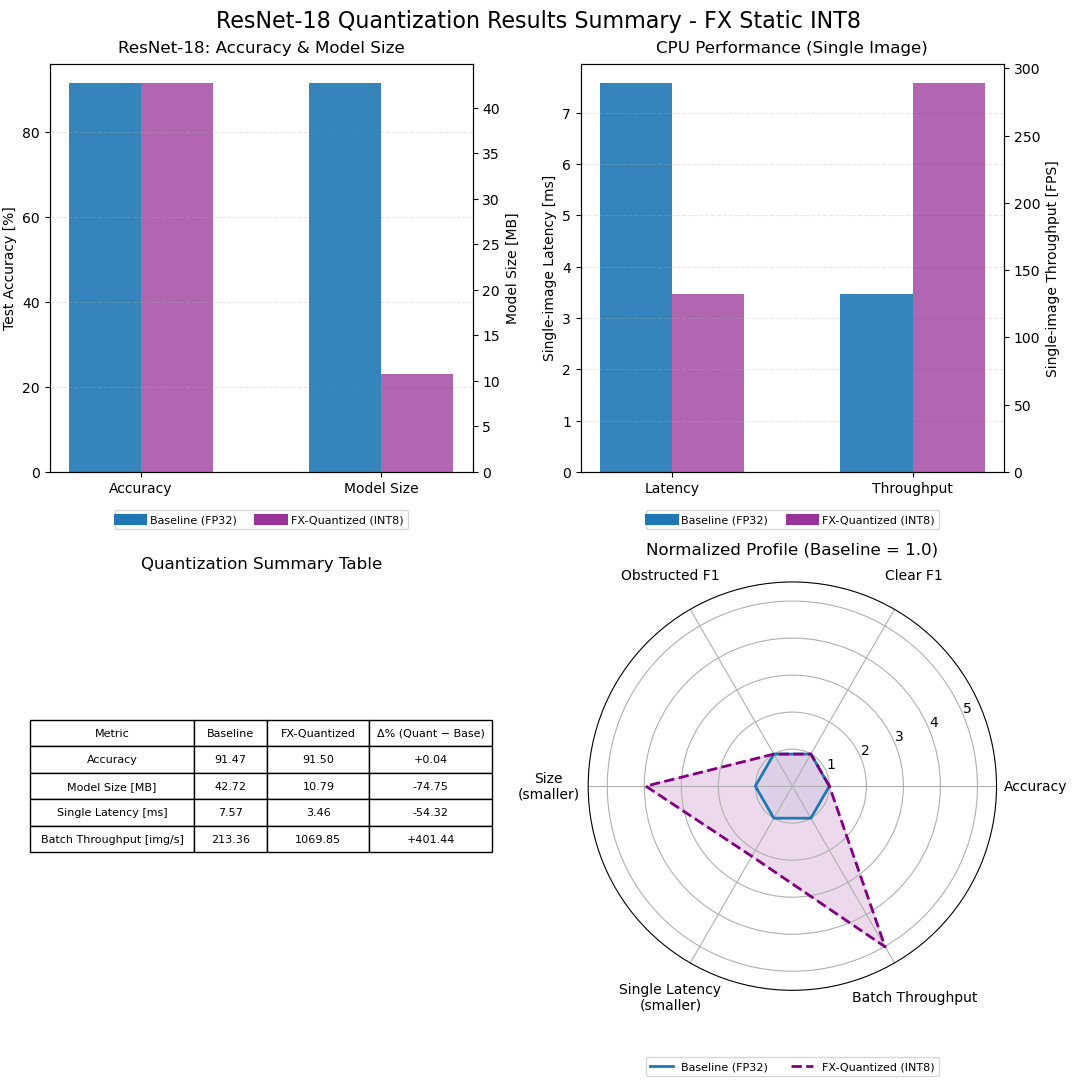

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Pull numbers (ResNet-18)
# -----------------------------
acc_base   = float(acc_r18)
acc_quant  = float(acc_r18_quant_fx)

f1_clear_base  = float(metrics_r18["clear"][2])
f1_clear_quant = float(metrics_r18_quant_fx["clear"][2])
f1_obst_base   = float(metrics_r18["obstructed"][2])
f1_obst_quant  = float(metrics_r18_quant_fx["obstructed"][2])

size_base  = float(baseline_r18_size_mb)
size_quant = float(quant_r18_fx_size_mb)

single_lat_base  = float(r18_latency_stats["single_mean_ms"])
single_lat_quant = float(r18_quant_latency_stats["single_mean_ms"])
single_fps_base  = float(r18_latency_stats["single_fps"])
single_fps_quant = float(r18_quant_latency_stats["single_fps"])

batch_lat_base   = float(r18_latency_stats["batch_mean_ms"])
batch_lat_quant  = float(r18_quant_latency_stats["batch_mean_ms"])
batch_fps_base   = float(r18_latency_stats["batch_fps"])
batch_fps_quant  = float(r18_quant_latency_stats["batch_fps"])

def pct_change(new, old):
    return (new - old) / old * 100.0

# -----------------------------
# Figure & axes
# -----------------------------
fig = plt.figure(figsize=(11, 11))
fig.suptitle("ResNet-18 Quantization Results Summary - FX Static INT8",
             fontsize=16, y=0.98)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

for ax in [ax1, ax2, ax3]:
    try:
        ax.set_box_aspect(1)
    except Exception:
        pass

baseline_color = "tab:blue"
quant_color    = "purple"
width = 0.3

# =======================================================
# Subplot 1 – Accuracy & Model Size (x = metrics)
# =======================================================
metrics1 = ["Accuracy", "Model Size"]
x = np.arange(len(metrics1))

ax1_left = ax1
ax1_right = ax1_left.twinx()

# Bars for Baseline / Quant – Accuracy (left axis)
acc_x = x[0]
ax1_left.bar(acc_x - width/2,
             acc_base * 100,
             width,
             color=baseline_color,
             alpha=0.9)
ax1_left.bar(acc_x + width/2,
             acc_quant * 100,
             width,
             color=quant_color,
             alpha=0.6)

# Bars for Baseline / Quant – Model Size (right axis)
size_x = x[1]
ax1_right.bar(size_x - width/2,
              size_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax1_right.bar(size_x + width/2,
              size_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax1_left.set_xticks(x)
ax1_left.set_xticklabels(metrics1)
ax1_left.set_ylabel("Test Accuracy [%]")
ax1_right.set_ylabel("Model Size [MB]")
ax1_left.set_title("ResNet-18: Accuracy & Model Size", pad=8)
ax1_left.grid(axis="y", linestyle="--", alpha=0.3)

handles1 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color,   lw=8, alpha=0.8,
               label="FX-Quantized (INT8)"),
]
ax1_left.legend(handles=handles1,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 2 – Latency & Throughput (x = metrics)
# =======================================================
metrics2 = ["Latency", "Throughput"]
x2 = np.arange(len(metrics2))

ax2_left = ax2
ax2_right = ax2_left.twinx()

# Latency bars (left axis) at "Latency"
lat_x = x2[0]
ax2_left.bar(lat_x - width/2,
             single_lat_base,
             width,
             color=baseline_color,
             alpha=0.9)
ax2_left.bar(lat_x + width/2,
             single_lat_quant,
             width,
             color=quant_color,
             alpha=0.6)

# Throughput bars (right axis) at "Throughput"
thr_x = x2[1]
ax2_right.bar(thr_x - width/2,
              single_fps_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax2_right.bar(thr_x + width/2,
              single_fps_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax2_left.set_xticks(x2)
ax2_left.set_xticklabels(metrics2)
ax2_left.set_ylabel("Single-image Latency [ms]")
ax2_right.set_ylabel("Single-image Throughput [FPS]")
ax2_left.set_title("CPU Performance (Single Image)", pad=8)
ax2_left.grid(axis="y", linestyle="--", alpha=0.3)

handles2 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color,   lw=8, alpha=0.8,
               label="FX-Quantized (INT8)"),
]
ax2_left.legend(handles=handles2,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 3 – Summary table
# =======================================================
ax3.axis("off")

table_data = [
    ["Accuracy",
     f"{acc_base*100:.2f}", f"{acc_quant*100:.2f}",
     f"{pct_change(acc_quant, acc_base):+.2f}"],
    ["Model Size [MB]",
     f"{size_base:.2f}", f"{size_quant:.2f}",
     f"{pct_change(size_quant, size_base):+.2f}"],
    ["Single Latency [ms]",
     f"{single_lat_base:.2f}", f"{single_lat_quant:.2f}",
     f"{pct_change(single_lat_quant, single_lat_base):+.2f}"],
    ["Batch Throughput [img/s]",
     f"{batch_fps_base:.2f}", f"{batch_fps_quant:.2f}",
     f"{pct_change(batch_fps_quant, batch_fps_base):+.2f}"],
]

col_labels = ["Metric", "Baseline", "FX-Quantized", "Δ% (Quant − Base)"]
col_widths = [0.40, 0.18, 0.25, 0.30]

table = ax3.table(cellText=table_data,
                  colLabels=col_labels,
                  loc="center",
                  cellLoc="center",
                  colWidths=col_widths)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.0, 1.5)
ax3.set_title("Quantization Summary Table", pad=10)

# =======================================================
# Subplot 4 – Radar / Spider
# =======================================================
radar_labels = [
    "Accuracy",
    "Clear F1",
    "Obstructed F1",
    "Size\n(smaller)",
    "Single Latency\n(smaller)",
    "Batch Throughput"
]

baseline_radar = np.ones(len(radar_labels))
quant_radar = np.array([
    acc_quant / acc_base,
    f1_clear_quant / f1_clear_base,
    f1_obst_quant / f1_obst_base,
    size_base / size_quant,
    single_lat_base / single_lat_quant,
    batch_fps_quant / batch_fps_base,
])

angles = np.linspace(0, 2*np.pi, len(radar_labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])
baseline_plot = np.concatenate([baseline_radar, baseline_radar[:1]])
quant_plot    = np.concatenate([quant_radar,   quant_radar[:1]])

ax4.plot(angles, baseline_plot, linewidth=2, color=baseline_color,
         label="Baseline (FP32)")
ax4.fill(angles, baseline_plot, alpha=0.08, color=baseline_color)

ax4.plot(angles, quant_plot, linewidth=2, linestyle="--", color=quant_color,
         label="FX-Quantized (INT8)")
ax4.fill(angles, quant_plot, alpha=0.15, color=quant_color)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(radar_labels)
ax4.set_ylim(0, max(1.2, quant_radar.max() * 1.1))
ax4.set_title("Normalized Profile (Baseline = 1.0)", pad=20)
ax4.tick_params(axis='x', pad=18)
ax4.set_aspect('equal', adjustable='box')

ax4.legend(loc="upper center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           fontsize=8)

plt.tight_layout()
plt.show()


In [16]:
import torch

# ResNet18 quantized full module
torch.save(r18_quant_fx, "resnet18_clear_obstructed_quant_fx_full.pt")

print("Saved full quantized ResNet18 module.")

Saved full quantized ResNet18 module.
